In [2]:
import torch
import torchvision
import os
import pandas as pd
from skimage import io
from fastprogress import master_bar, progress_bar
import numpy as np
from sklearn.metrics import roc_auc_score
from skimage.transform import resize
import sys
from albumentations import Compose, Flip, ChannelShuffle, ToSepia,HorizontalFlip, RandomBrightnessContrast, ElasticTransform, GridDistortion

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__, DEVICE


('1.10.0', 'cuda')

In [47]:
torch.randn(2, device=DEVICE)

tensor([-0.0432, -0.5007], device='cuda:0')

In [3]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
__pyTorch VERSION: 1.10.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [4]:
PATH = 'data'
os.listdir(PATH)

['all.txt',
 'PATCHES',
 'submission.csv',
 'test.csv',
 'train.csv',
 'validation.csv']

In [5]:
train = pd.read_csv(f'{PATH}/train.csv')
val = pd.read_csv(f'{PATH}/validation.csv')

train.shape, val.shape

((18120, 2), (1812, 2))

In [6]:
trans = Compose([
    HorizontalFlip(),
    #RandomBrightnessContrast(),
    #Equalize(),
    ToSepia(),
    GridDistortion(),
    ChannelShuffle()
])

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, train=True, trans=None):
        self.images = images
        self.labels = labels
        self.train = train
        self.trans = trans

    def __len__(self):
        return len(self.images)

    def load_img(self, img):
        return resize(io.imread(img),(150, 150, 3))#.astype(np.float64)
        #return io.imread(img)

    def __getitem__(self, ix):
        img = self.load_img(self.images[ix])
        #print(img.dtype)
        if self.trans:
            img = self.trans(image=img)['image']
        #img = resize(img, (150, 150, 3))
        if self.train:
            return torch.from_numpy(img), torch.tensor([self.labels[ix]]).float()
        return torch.from_numpy(img)

In [8]:
dataset = {
    'train': Dataset(train["0"], train["1"], trans=trans),
    'val': Dataset(val["0"], val["1"], trans=trans),
}

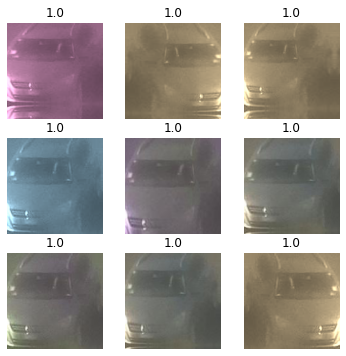

In [30]:
import matplotlib.pyplot as plt
import random

r, c = 3, 3
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = 1#random.randint(0, len(dataset['val'])-1)
        img, label = dataset['train'][ix]
        plt.imshow(img)
        plt.title(f"{label.item()}")
        plt.axis(False)
plt.show()

In [10]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torchvision.models.resnet50(pretrained=True)
        # freeze
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.encoder.fc = torch.nn.Linear(2048, 1)

    def forward(self, x):
        B, H, W, C = x.shape
        x = (x / 255.).float().view(B, C, H, W)
        x = self.encoder(x)
        return x

In [11]:
BATCH_SIZE = 64

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BATCH_SIZE)
}

In [12]:
imgs, labels = next(iter(dataloader['val']))

imgs.shape, labels.shape

(torch.Size([64, 150, 150, 3]), torch.Size([64, 1]))

In [13]:
def AUC(outputs, labels):
    outputs = torch.sigmoid(outputs)
    outputs = outputs.numpy()
    labels = labels.numpy()
    auc = roc_auc_score(labels, outputs)
    return auc

In [ ]:
net = Net()
net.to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

EPOCHS = 20
validation_steps = None
mb = master_bar(range(1, EPOCHS+1))
best_auc = 0
for epoch in mb:
    train_loss = []
    net.train()
    for batch in progress_bar(dataloader['train'], parent=mb):
        imgs, labels = batch
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = net(imgs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        mb.child.comment = f'loss {np.mean(train_loss):.5f}'

    val_loss = []
    net.eval()
    validation_step = 0
    val_outputs = torch.tensor([])
    val_targets = torch.tensor([])
    with torch.no_grad():
        for batch in progress_bar(dataloader['val'], parent=mb):
            imgs, labels = batch
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            mb.child.comment = f'val_loss {np.mean(val_loss):.5f}'
            val_outputs = torch.cat([val_outputs, outputs.cpu()])
            val_targets = torch.cat([val_targets, labels.cpu()])
            validation_step += 1
            if validation_steps:
                if validation_step > validation_steps:
                    break
    auc = AUC(val_outputs, val_targets)
    if auc > best_auc:
        best_auc = auc
        torch.save(net, 'model_da.pth')
        print(f"Best model ! Val AUC {auc:.5f}")
    mb.write(f'Epoch {epoch}/{EPOCHS} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} val_auc {auc:.5f}') #val_loss {np.mean(val_loss):.5f} val_auc {auc:.5f}')

tensor(0.1225, device='cuda:0')
tensor(0.1257, device='cuda:0')
tensor(0.1414, device='cuda:0')
tensor(0.2823, device='cuda:0')
tensor(0.1782, device='cuda:0')
tensor(0.2190, device='cuda:0')
tensor(0.1359, device='cuda:0')
tensor(0.1176, device='cuda:0')
tensor(0.1910, device='cuda:0')
tensor(0.1643, device='cuda:0')
tensor(0.1422, device='cuda:0')
tensor(0.1286, device='cuda:0')
tensor(0.2490, device='cuda:0')
tensor(0.1062, device='cuda:0')
tensor(0.2571, device='cuda:0')
tensor(0.1320, device='cuda:0')
tensor(0.2114, device='cuda:0')
tensor(0.0747, device='cuda:0')
tensor(0.2137, device='cuda:0')
tensor(0.2086, device='cuda:0')
tensor(0.1492, device='cuda:0')
tensor(0.1621, device='cuda:0')
tensor(0.1155, device='cuda:0')
tensor(0.1638, device='cuda:0')
tensor(0.2751, device='cuda:0')
tensor(0.1296, device='cuda:0')
tensor(0.1746, device='cuda:0')
tensor(0.2387, device='cuda:0')
tensor(0.1340, device='cuda:0')
Best model ! Val AUC 0.98301
tensor(0.1151, device='cuda:0')
tensor(0.11

tensor(0.1222, device='cuda:0')
tensor(0.1648, device='cuda:0')
tensor(0.0814, device='cuda:0')
tensor(0.1642, device='cuda:0')
tensor(0.2869, device='cuda:0')
tensor(0.1602, device='cuda:0')
Best model ! Val AUC 0.98961
tensor(0.1549, device='cuda:0')
tensor(0.0734, device='cuda:0')
tensor(0.0595, device='cuda:0')
tensor(0.2062, device='cuda:0')
tensor(0.1365, device='cuda:0')
tensor(0.1822, device='cuda:0')
tensor(0.0861, device='cuda:0')
tensor(0.0630, device='cuda:0')
tensor(0.1268, device='cuda:0')
tensor(0.1593, device='cuda:0')
tensor(0.1253, device='cuda:0')
tensor(0.1432, device='cuda:0')
tensor(0.0795, device='cuda:0')
tensor(0.1760, device='cuda:0')
tensor(0.3387, device='cuda:0')
tensor(0.0370, device='cuda:0')
tensor(0.1367, device='cuda:0')
tensor(0.0606, device='cuda:0')
tensor(0.1612, device='cuda:0')
tensor(0.0895, device='cuda:0')
tensor(0.1014, device='cuda:0')
tensor(0.1182, device='cuda:0')
tensor(0.1068, device='cuda:0')
tensor(0.1256, device='cuda:0')
tensor(0.12

In [165]:
test = pd.read_csv(f'{PATH}/test.csv')

test.head()

,0,1
0,data/PATCHES/SUNNY/2016-01-18/camera6/S_2016-0...,1
1,data/PATCHES/SUNNY/2016-01-16/camera8/S_2016-0...,0
2,data/PATCHES/OVERCAST/2015-11-16/camera7/O_201...,1
3,data/PATCHES/OVERCAST/2015-11-25/camera3/O_201...,1
4,data/PATCHES/SUNNY/2015-12-17/camera3/S_2015-1...,0


In [166]:
test_dataset = Dataset(test['0'],test['1'], train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=200)

In [167]:
imgs = next(iter(test_dataloader))
imgs.shape

torch.Size([200, 150, 150, 3])

In [168]:
model = torch.load('model.pth')
model.to(DEVICE)
model.eval()
preds = torch.tensor([]).to(DEVICE)
with torch.no_grad():
    for imgs in progress_bar(test_dataloader):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        outputs = torch.sigmoid(outputs)
        preds = torch.cat([preds, outputs.view(-1)])
        

In [171]:
submission = pd.DataFrame({'image_name': test['0'].values, 'real': test['1'].values,'target': np.round(preds.cpu().numpy()).astype(int)})

submission

,image_name,real,target
0,data/PATCHES/SUNNY/2016-01-18/camera6/S_2016-0...,1,1
1,data/PATCHES/SUNNY/2016-01-16/camera8/S_2016-0...,0,0
2,data/PATCHES/OVERCAST/2015-11-16/camera7/O_201...,1,1
3,data/PATCHES/OVERCAST/2015-11-25/camera3/O_201...,1,1
4,data/PATCHES/SUNNY/2015-12-17/camera3/S_2015-1...,0,0
...,...,...,...
9995,data/PATCHES/OVERCAST/2015-12-19/camera6/O_201...,0,0
9996,data/PATCHES/OVERCAST/2015-12-19/camera9/O_201...,0,0
9997,data/PATCHES/RAINY/2016-01-14/camera1/R_2016-0...,1,1
9998,data/PATCHES/OVERCAST/2015-11-16/camera2/O_201...,1,1


In [26]:
len(submission[submission['real'] == submission['target']]) / len(submission), len(submission[submission['real'] != submission['target']]) / len(submission)

(0.9563, 0.0437)